# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [5]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[27:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [6]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


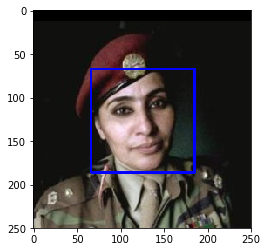

In [7]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x, y, w, h) in faces:
    # add bounding box to color image
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

- 100% of the first 100 images in `human_files` have a detected human face.
- 11% of the first 100 images in dog `dog_files` have a detected human face.

In the code cell below the next one, I run an additional assessment that randomly selects 100 images in each of `human_files` and `dog_files` and checks what percentage of the images have a detected human face. The measurement is repeated 100 times and the average performance is reported. Here, we see average performances of 95% and 8.0%, respectively, for `human_files` and `dog_files`.

In [9]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_in_human = np.sum([face_detector(img) for img in human_files_short])
human_in_dog = np.sum([face_detector(img) for img in dog_files_short])

print('% of detected human face in human_files_short:', human_in_human)
print('% of detected human face in dog_files_short:', human_in_dog)

% of detected human face in human_files_short: 100
% of detected human face in dog_files_short: 11


In [10]:
# Assess performance a little more in depth.

def human_face_detector_perf():

    for _ in range(100):
        
        np.random.seed(42)
        
        scores_human = []
        scores_dog = []
        random_indices = np.random.choice(1000, 100)
        human_files_test = human_files[random_indices]
        dog_files_test = train_files[random_indices]

        scores_human.append(np.sum([face_detector(img) for img in human_files_test]))
        scores_dog.append(np.sum([face_detector(img) for img in dog_files_test]))
        
        return np.mean(scores_human), np.mean(scores_dog)
    
human_face_detector_perf()

(95.0, 8.0)

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

I think that this is a reasonable expectation, especially given the ease with which photographs can be taken nowadays due to the prevalence of mobile phone cameras. I did not implement this here, but one idea would be to use the dog and human image sets to train a CNN that predicts on only those two classes. One could try to implement data augmentation on the human images to artificially generate images that are off-centered, rotated, distorted, etc. This might result in a model that is trained to recognize humans even on inputs photographs that do not provide a clear view of a face. Then, instead of using the Haar cascade plus the pre-trained ResNet-50 model as the respective human face and dog detectors, one could try using only the trained CNN described as the sole detector.

In [11]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [12]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [13]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [14]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- 0% of the images in `human_files_short` have a detected dog.
- 100% of the images in `dog_files_short` have a detected dog.

Again, two code cells below I run an additional assessment that randomly selects 100 images in each of `human_files` and `dog_files` and checks what percentage of the images have a detected dog. The measurement is repeated 100 times and the average performance is reported. Here, we see average performances of 2% and 100%, respectively, for `human_files` and `dog_files`.

In [16]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_in_human = np.sum([dog_detector(img) for img in human_files_short])
dog_in_dog = np.sum([dog_detector(img) for img in dog_files_short])

print('% of detected dog face in human_files_short:', dog_in_human)
print('% of detected dog face in dog_files_short:', dog_in_dog)

% of detected dog face in human_files_short: 0
% of detected dog face in dog_files_short: 100


In [17]:
# Assess performance a little more carefully.

def dog_face_detector_perf():

    for _ in range(100):
        
        np.random.seed(42)
        
        scores_human = []
        scores_dog = []
        random_indices = np.random.choice(1000, 100)
        human_files_test = human_files[random_indices]
        dog_files_test = train_files[random_indices]

        scores_human.append(np.sum([dog_detector(img) for img in human_files_test]))
        scores_dog.append(np.sum([dog_detector(img) for img in dog_files_test]))
        
        return np.mean(scores_human), np.mean(scores_dog)
    
dog_face_detector_perf()

(2.0, 100.0)

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [18]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32') / 255
valid_tensors = paths_to_tensor(valid_files).astype('float32') / 255
test_tensors = paths_to_tensor(test_files).astype('float32') / 255

100%|██████████| 836/836 [00:08<00:00, 102.51it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

My starting point for the following step was the following. The most common strategy I have seen for CNNs is to--with each subsequent layer--gradually reduce the height and width of the original input image while gradually increasing the depth, using a combination of convolutional and pooling layers. That appears to be the idea with the proposed network above as well. Therefore, I decided to use repeated blocks of CONV->BatchNorm->RELU->MaxPool->Dropout, with valid convolutions (except in the last model). Since the goal here was only to obtain >1% test accuracy after 5 epochs, I decided to keep the CNN relatively shallow (3-4 layers), and I tried to avoid architectures with a large number (> 1 million) parameters. So, I did not add any fully connected layers other than the final softmax output layer.

In transitioning from model to model, I mainly played around with the number of filters in each layer and the kernel size. I threw dropout in just to do it, but I don't think I would typically add dropout layers until I saw evidence of overfitting. Here, since I terminated the training after only 5 epochs, I didn't really see any clear signs of overfitting. I used the same optimizer each time (Adam w/ 0.001 learning rate) and a mini-batch size of 32.

Here are some of the networks I tried out:

<b>MODEL 1 (~685k parameters)</b>

Input -> <br>
CONV (32 filters, 9x9 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (64 filters, 9x9 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (96 filters, 9x9 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
GlobalAvg --> <br>
FC (softmax)

Test accuracy (5 epochs): 5.2632%, 5.6220%

<b>MODEL 2 (~88k parameters)</b>

Input -> <br>
CONV (32 filters, 3x3 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (64 filters, 3x3 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (96 filters, 3x3 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
GlobalAvg --> <br>
FC (softmax)

Test accuracy (5 epochs): 3.2297%, 4.7847%

<b>MODEL 3 (~220k parameters)</b>

Input -> <br>
CONV (16 filters, 9x9 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (32 filters, 9x9 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (64 filters, 9x9 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
GlobalAvg --> <br>
FC (softmax)

Test accuracy (5 epochs): 1.7943%

<b>MODEL 4 (~136k parameters)</b>

Input -> <br>
CONV (16 filters, 7x7 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (32 filters, 7x7 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (64 filters, 7x7 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
GlobalAvg --> <br>
FC (softmax)

Test accuracy (5 epochs): 4.6651%

<b>MODEL 5 (~32k parameters)</b>

Input -> <br>
CONV (16 filters, 3x3 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (32 filters, 3x3 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (64 filters, 3x3 kernel, valid) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
GlobalAvg --> <br>
FC (softmax)

Test accuracy (5 epochs): 2.9904%

<b>MODEL 6 (~32k parameters)</b>

Input -> <br>
CONV (16 filters, 3x3 kernel, same) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (32 filters, 3x3 kernel, same) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
CONV (64 filters, 3x3 kernel, same) -> BatchNorm -> RELU -> MaxPool (2x2) --> Dropout (0.1) --> <br>
GlobalAvg --> <br>
FC (softmax)

Test accuracy (5 epochs): 2.5120%


Given that training was stopped after just 5 epochs, I am not sure how well the models can be compared, but all of them provided over 1% test accuracy. Were I to consider actually optimizing the network, I would perform a more thorough grid search and try more architectures. In order to get a better idea regarding overfitting, I think one would have to let the training run longer to get a wider view of the learning curves. One other reason I hesitate to compare these models too much is that, although I tried to initialize the same layer weights for each training by seeding the kernel_initializer, I did find that re-compiling and re-training the same model multiple times did lead to slightly different test accuracies each time. I demonstrate this above by listing a couple values for the first two models. For a fairer comparison, one would probably want to either average the results of a few runs, or learn to seed the entire model properly to avoid any randomness.

Moving foward, I would probably start with Model 1, as it does seem to give the best performance on the test set, which maybe doesn't surprise me too much because it results in the highest depth with 96 filters (however, bearing in mind what I mention above about needing to run the training longer and comparing the models fairly).

In [19]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.initializers import glorot_normal
from keras.regularizers import l2

model = Sequential()

### TODO: Define your architecture.
# conv layer 1
model.add(Conv2D(filters=32, kernel_size=9, padding='valid', kernel_initializer=glorot_normal(seed=0), input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

# conv layer 2
model.add(Conv2D(filters=64, kernel_size=9, padding='valid', kernel_initializer=glorot_normal(seed=0)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

# conv layer 3
model.add(Conv2D(filters=96, kernel_size=9, padding='valid', kernel_initializer=glorot_normal(seed=0)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

# global avg
model.add(GlobalAveragePooling2D())

# fc
model.add(Dense(133, activation='softmax', kernel_initializer=glorot_normal(seed=0)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 216, 216, 32)      7808      
_________________________________________________________________
batch_normalization_1 (Batch (None, 216, 216, 32)      128       
_________________________________________________________________
activation_50 (Activation)   (None, 216, 216, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 108, 108, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      165952    
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 100, 64)      256       
__________

### Compile the Model

In [20]:
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [21]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 63s 9ms/step - loss: 4.7644 - acc: 0.0201 - val_loss: 4.8838 - val_acc: 0.0180
Epoch 2/5
6680/6680 [==============================] - 59s 9ms/step - loss: 4.5675 - acc: 0.0394 - val_loss: 5.6064 - val_acc: 0.0120
Epoch 3/5
6680/6680 [==============================] - 59s 9ms/step - loss: 4.4290 - acc: 0.0493 - val_loss: 5.3616 - val_acc: 0.0168
Epoch 4/5
6680/6680 [==============================] - 59s 9ms/step - loss: 4.2877 - acc: 0.0633 - val_loss: 4.6068 - val_acc: 0.0359
Epoch 5/5
6680/6680 [==============================] - 59s 9ms/step - loss: 4.1617 - acc: 0.0741 - val_loss: 4.5911 - val_acc: 0.0455


### Load the Model with the Best Validation Loss

In [22]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [23]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1)) / len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.9474%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [24]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [25]:
# Add batch normalization layer to improve test accuracy from 44% -> 76%

VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

# VGG16_model = Sequential()
# VGG16_model.add(BatchNormalization(input_shape=train_VGG16.shape[1:]))
# VGG16_model.add(GlobalAveragePooling2D())
# VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [26]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [27]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 330us/step - loss: 12.4237 - acc: 0.1231 - val_loss: 10.9952 - val_acc: 0.2144
Epoch 2/20
6680/6680 [==============================] - 2s 288us/step - loss: 10.4546 - acc: 0.2692 - val_loss: 10.3388 - val_acc: 0.2826
Epoch 3/20
6680/6680 [==============================] - 2s 289us/step - loss: 10.0310 - acc: 0.3213 - val_loss: 10.3048 - val_acc: 0.2994
Epoch 4/20
6680/6680 [==============================] - 2s 288us/step - loss: 9.7945 - acc: 0.3494 - val_loss: 10.0602 - val_acc: 0.3066
Epoch 5/20
6680/6680 [==============================] - 2s 289us/step - loss: 9.5992 - acc: 0.3708 - val_loss: 10.0080 - val_acc: 0.3174
Epoch 6/20
6680/6680 [==============================] - 2s 288us/step - loss: 9.4355 - acc: 0.3858 - val_loss: 9.8080 - val_acc: 0.3246
Epoch 7/20
6680/6680 [==============================] - 2s 284us/step - loss: 9.2433 - acc: 0.3996 - val_loss: 9.6536 - val_acc: 

### Load the Model with the Best Validation Loss

In [28]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [29]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1)) / len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 41.6268%


### Predict Dog Breed with the Model

In [30]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [31]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('/data/bottleneck_features/DogInceptionV3Data.npz')
train_Inception = bottleneck_features['train']
valid_Inception = bottleneck_features['valid']
test_Inception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I used the InceptionV3 network as the base, mainly because I think the Inception network has a neat architecture, and wanted to see how it performs. Actually, I stuck with almost the same top model as used above for VGG16 example as a starting point, except that I added the BatchNormalization layer at the front because I noticed that it dramatically increased the performance of the VGG16 transfer learning. Next, I tried to add a couple fully connected layers (1000 and 500 nodes) with dropout before the softmax layer, but these did not seem to help the performance, so I removed them. I also tried just a single fully connected layer (1000 nodes), but again, it did not seem to help the performance. In the end, I was not really able to improve the performance much beyond what is shown below, so I decided that this would be the final model.

However, this left me wanting a bit more, so I do try data augmentation below, but very disappointingly could not improve the performance. I thought perhaps there was some evidence of overfitting (95% acccuracy on the training set, 83-84% accuracy on the test set), so I believed that data augmentation might serve to help with that. 

At some point later I'd like to maybe try fine tuning in addition to data augmentation, perhaps I can squeeze out a bit more accuracy on the test set. But I'm satisfied with this result for the time being.

In [32]:
### TODO: Define your architecture.

Inception_model = Sequential()
Inception_model.add(BatchNormalization(input_shape=train_Inception.shape[1:]))
Inception_model.add(GlobalAveragePooling2D())
Inception_model.add(Dense(133, activation='softmax'))

Inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 5, 5, 2048)        8192      
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 280,709
Trainable params: 276,613
Non-trainable params: 4,096
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [33]:
### TODO: Compile the model.

from keras.optimizers import Adam, RMSprop

Inception_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [34]:
### TODO: Train the model.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', 
                               verbose=1, save_best_only=True)

Inception_model.fit(train_Inception, train_targets, 
          validation_data=(valid_Inception, valid_targets),
          epochs=15, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/15
6680/6680 [==============================] - 2s 346us/step - loss: 3.3649 - acc: 0.3638 - val_loss: 1.9204 - val_acc: 0.7042
Epoch 2/15
6680/6680 [==============================] - 2s 282us/step - loss: 1.3496 - acc: 0.7534 - val_loss: 0.9337 - val_acc: 0.7892
Epoch 3/15
6680/6680 [==============================] - 2s 281us/step - loss: 0.7822 - acc: 0.8253 - val_loss: 0.6885 - val_acc: 0.8180
Epoch 4/15
6680/6680 [==============================] - 2s 282us/step - loss: 0.5882 - acc: 0.8582 - val_loss: 0.5985 - val_acc: 0.8299
Epoch 5/15
6680/6680 [==============================] - 2s 284us/step - loss: 0.4867 - acc: 0.8765 - val_loss: 0.5509 - val_acc: 0.8443
Epoch 6/15
6680/6680 [==============================] - 2s 282us/step - loss: 0.4225 - acc: 0.8943 - val_loss: 0.5242 - val_acc: 0.8551
Epoch 7/15
6680/6680 [==============================] - 2s 283us/step - loss: 0.3761 - acc: 0.9055 - val_loss: 0.5065 - val_acc: 0.8599
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [35]:
### TODO: Load the model weights with the best validation loss.

Inception_model.load_weights('saved_models/weights.best.Inception.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [36]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Inception_predictions = [np.argmax(Inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.7321%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [37]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# Note: I have two outputs on this function rather than just the one. The second output is utilized in step 6. 

def predict_breed(img_path):
    # extract bottleneck features
    bottleneck_features = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Inception_model.predict(bottleneck_features)
    # return predicted dog breed
    return dog_names[np.argmax(predicted_vector)], np_utils.to_categorical(np.argmax(predicted_vector), 133)[0]

## Step 5 with data augmentation

### Method 1: Create augmented dataset first, then create bottleneck features

In [38]:
def inception_bottleneck_augmented_v1():
    
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    from keras.preprocessing.image import ImageDataGenerator

    # Import inception base model
    inception_base = InceptionV3(weights='imagenet', include_top=False)

    # Create and configure augmented image generator
    datagen_train = ImageDataGenerator(
        width_shift_range=0.1,   # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)    # randomly flip images horizontally

    datagen_valid = ImageDataGenerator(
        width_shift_range=0.2,   # randomly shift images horizontally
        height_shift_range=0.2,  # randomly shift images vertically
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)    # randomly flip images horizontally

    # Load train/valid tensors 
    train_tensors = paths_to_tensor(train_files).astype('float32')
    valid_tensors = paths_to_tensor(valid_files).astype('float32')

    # Fit augmented image generator on data
    datagen_train.fit(train_tensors)
    datagen_valid.fit(valid_tensors)

    # Generate augmented data
    train_tensors_augmented = []
    train_targets_augmented = []
    valid_tensors_augmented = []
    valid_targets_augmented = []

    batch_size = 32
    num_augmented = 0

    for X_batch, y_batch in datagen_train.flow(train_tensors, train_targets, batch_size=batch_size, shuffle=False):
        train_tensors_augmented.append(X_batch)
        train_targets_augmented.append(y_batch)
        num_augmented += batch_size
        if num_augmented >= train_targets.shape[0]:
            break

    train_tensors_augmented = np.concatenate(train_tensors_augmented)
    train_targets_augmented = np.concatenate(train_targets_augmented)

    num_augmented = 0

    for X_batch, y_batch in datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size, shuffle=False):
        valid_tensors_augmented.append(X_batch)
        valid_targets_augmented.append(y_batch)
        num_augmented += batch_size
        if num_augmented >= valid_targets.shape[0]:
            break

    valid_tensors_augmented = np.concatenate(valid_tensors_augmented)
    valid_targets_augmented = np.concatenate(valid_targets_augmented)

    train_tensors_augmented = np.vstack([train_tensors_augmented, train_tensors])
    train_targets_augmented = np.vstack([train_targets_augmented, train_targets])
    valid_tensors_augmented = np.vstack([valid_tensors_augmented, valid_tensors])
    valid_targets_augmented = np.vstack([valid_targets_augmented, valid_targets])

    # Calculate bottleneck features (don't forget to pre-process imput for ImageNet (see Making Predictions with ResNet-50))
    train_Inception_augmented = inception_base.predict(preprocess_input(train_tensors_augmented)) 
    valid_Inception_augmented = inception_base.predict(preprocess_input(valid_tensors_augmented))
    
    return train_Inception_augmented, train_targets_augmented, valid_Inception_augmented, valid_targets_augmented

### Method 2: Use predict_generator method to generate bottleneck features on the fly

In [39]:
def inception_bottleneck_augmented_v2():
    
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    from keras.preprocessing.image import ImageDataGenerator

    # Import inception base model
    inception_base = InceptionV3(weights='imagenet', include_top=False)

    # Create and configure augmented image generator
    datagen_train = ImageDataGenerator(
        preprocessing_function=preprocess_input, # don't forget to pre-process imput for ImageNet (see Making Predictions with ResNet-50)
        width_shift_range=0.1,                   # randomly shift images horizontally (10% of total width)
        height_shift_range=0.1,                  # randomly shift images vertically (10% of total height)
        horizontal_flip=True)                    # randomly flip images horizontally

    datagen_valid = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        width_shift_range=0.1,   
        height_shift_range=0.1,
        horizontal_flip=True)

    # Load train/valid tensors
    train_tensors = paths_to_tensor(train_files).astype('float32')
    valid_tensors = paths_to_tensor(valid_files).astype('float32')

    # Fit augmented image generator on data
    datagen_train.fit(train_tensors)
    datagen_valid.fit(valid_tensors)

    # Generate bottleneck features
    bneck_train_augmented = inception_base.predict_generator(datagen_train.flow(train_tensors, train_targets, batch_size=32, shuffle=False),
                                                             steps=train_tensors.shape[0] // 32)

    bneck_valid_augmented = inception_base.predict_generator(datagen_valid.flow(valid_tensors, valid_targets, batch_size=32, shuffle=False),
                                                             steps=valid_tensors.shape[0] // 32)

    num_train_augmented = 32 * (train_tensors.shape[0] // 32)
    num_valid_augmented = 32 * (valid_tensors.shape[0] // 32)

    train_Inception_augmented = np.vstack([bneck_train_augmented, train_Inception])
    train_targets_augmented = np.vstack([train_targets[:num_train_augmented], train_targets])
    valid_Inception_augmented = np.vstack([bneck_valid_augmented, valid_Inception])
    valid_targets_augmented = np.vstack([valid_targets[:num_valid_augmented], valid_targets])
    
    return train_Inception_augmented, train_targets_augmented, valid_Inception_augmented, valid_targets_augmented

In [40]:
# Load bottleneck features (augmented dataset)

train_Inception_augmented, train_targets_augmented, valid_Inception_augmented, valid_targets_augmented = inception_bottleneck_augmented_v1()

87916544/87910968 [==============================] - 1s 0us/step


100%|██████████| 835/835 [00:20<00:00, 40.66it/s]


In [41]:
# Load model

InceptionV3_augmented = Sequential()
InceptionV3_augmented.add(BatchNormalization(input_shape=train_Inception.shape[1:]))
InceptionV3_augmented.add(GlobalAveragePooling2D())
InceptionV3_augmented.add(Dense(133, activation='softmax', kernel_initializer=glorot_normal(seed=0)))

InceptionV3_augmented.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_99 (Batc (None, 5, 5, 2048)        8192      
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 280,709
Trainable params: 276,613
Non-trainable params: 4,096
_________________________________________________________________


In [42]:
# Compile model

InceptionV3_augmented.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])

In [43]:
# Train model

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception_augmented.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_augmented.fit(train_Inception_augmented, train_targets_augmented, 
                          validation_data=(valid_Inception_augmented, valid_targets_augmented),
                          epochs=15, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 13360 samples, validate on 1670 samples
Epoch 1/15
13360/13360 [==============================] - 6s 435us/step - loss: 2.3590 - acc: 0.5701 - val_loss: 1.0163 - val_acc: 0.7766
Epoch 2/15
13360/13360 [==============================] - 4s 293us/step - loss: 0.7077 - acc: 0.8332 - val_loss: 0.6629 - val_acc: 0.8257
Epoch 3/15
13360/13360 [==============================] - 4s 300us/step - loss: 0.4886 - acc: 0.8737 - val_loss: 0.5822 - val_acc: 0.8353
Epoch 4/15
13360/13360 [==============================] - 4s 304us/step - loss: 0.3986 - acc: 0.8959 - val_loss: 0.5513 - val_acc: 0.8449
Epoch 5/15
13360/13360 [==============================] - 4s 304us/step - loss: 0.3445 - acc: 0.9076 - val_loss: 0.5372 - val_acc: 0.8467
Epoch 6/15
13360/13360 [==============================] - 4s 303us/step - loss: 0.3035 - acc: 0.9174 - val_loss: 0.5272 - val_acc: 0.8467
Epoch 7/15
13360/13360 [==============================] - 4s 304us/step - loss: 0.2724 - acc: 0.9275 - val_loss: 0.5285 - v

In [44]:
InceptionV3_augmented.load_weights('saved_models/weights.best.Inception_augmented.hdf5')

In [45]:
# get index of predicted dog breed for each image in test set
Inception_predictions = [np.argmax(InceptionV3_augmented.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1)) / len(Inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.2536%


Not really any difference! :(

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [65]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

import matplotlib.image as mpimg

def get_similar_dog(array):
    """Get photo of dog similar to human. Input is the second output returned from predict_breed."""
    
    for i, target in enumerate(train_targets):
        if np.array_equal(target, array):
            return i
        

def main(img_path):
    "Returns predicted dog breed for input image of dog or similar dog breed for input image of human."
    
    if not face_detector(img_path) and not dog_detector(img_path):
        print('Error: please try uploading a different image.')
        fig = plt.figure()
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mpimg.imread(img_path))
        plt.show()
    elif dog_detector(img_path):
        predicted_breed, _ = predict_breed(img_path)
        fig = plt.figure()
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mpimg.imread(img_path))
        if predicted_breed[0].lower() in 'aeiou':
            print('This dog is an', predicted_breed)
        else:
            print('This dog is a', predicted_breed)
        plt.show()
    else:
        predicted_breed, array = predict_breed(img_path)
        try:
            similar_dog = train_files[get_similar_dog(array)]
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.set_xticks([])
            ax1.set_yticks([])
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax1.imshow(mpimg.imread(img_path))
            ax2.imshow(np.squeeze(path_to_tensor(similar_dog)) * 255)
            if predicted_breed[0].lower() in 'aeiou':
                print('You look like an', predicted_breed)
            else:
                print('You look like a', predicted_breed)
            plt.show()
        except IndexError:
            fig = plt.figure()
            plt.xticks([])
            plt.yticks([])
            plt.imshow(mpimg.imread(img_path))
            if predicted_breed[0].lower() in 'aeiou':
                print('You look like an', predicted_breed)
            else:
                print('You look like a', predicted_breed)
            plt.show()

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Overall, I am quite impressed! Apart from the hilarity of seeing my colleagues and wife compared to dog breeds, the algorithm/classifier performed quite well in my opinion. It nailed the Akita and the Golden Retriever and rejected the monkey and fish. What I did notice is the misclassifications occured on dog breeds that look very similar, but perhaps differ in size. This is reasonable. For example, the second 'Akita' is actually a Shiba Inu, which does look quite similar to the Akita, but it quite a bit smaller. The 'Giant Schauzer' is actually a Scottish Terrier, but again, they look quite similar, except that the terrier is much smaller.

In [58]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

You look like a Lhasa_apso


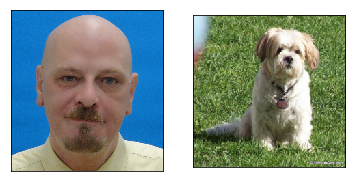

You look like an Australian_cattle_dog


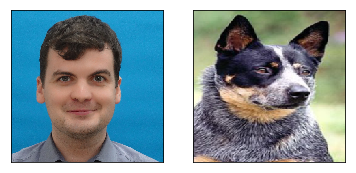

This dog is an Akita


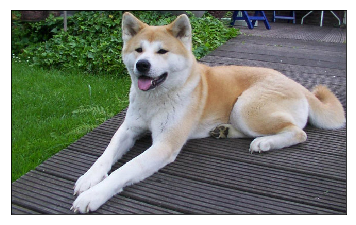

This dog is an Alaskan_malamute


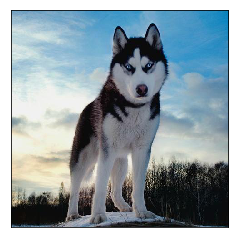

This dog is a Golden_retriever


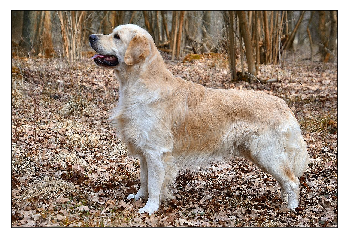

You look like a Norwegian_elkhound


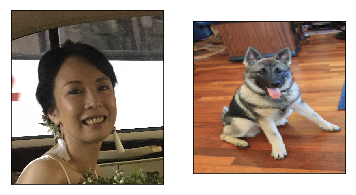

You look like an Akita


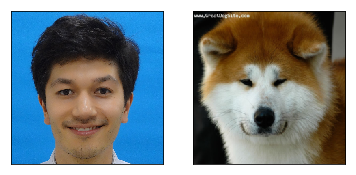

This dog is a Silky_terrier


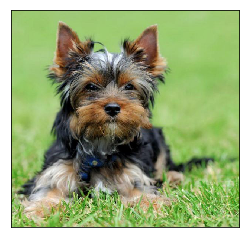

Error: please try uploading a different image.


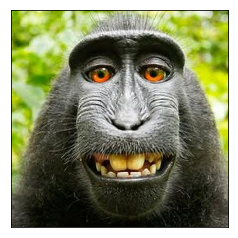

Error: please try uploading a different image.


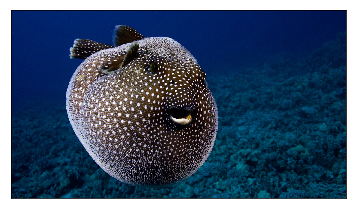

This dog is an Akita


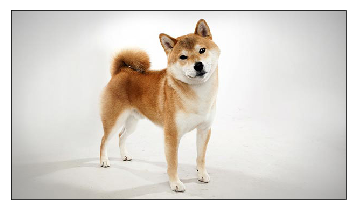

You look like a Cardigan_welsh_corgi


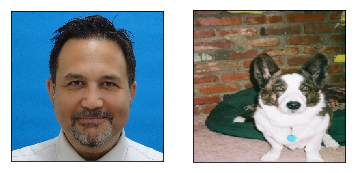

This dog is a Giant_schnauzer


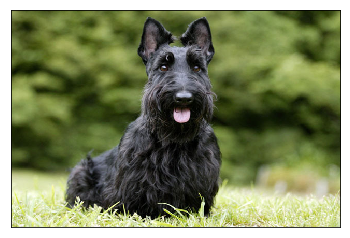

You look like a Komondor


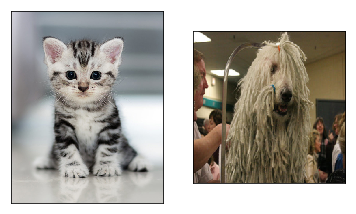

In [66]:
import os

root = 'sample_images/'
for filename in os.listdir('sample_images'):
    if filename[-3:].lower() == 'jpg':
        path = root + filename
        main(path)

# Please download your notebook to submit